# Sales Forecasting

One of the most important tasks for any retail store company is to analyze the performance of its stores. The main challenge faced by any retail store is predicting in advance the sales and inventory required at each store to avoid over-stocking and under-stocking. This helps the business to provide the best customer experience and avoid getting into losses, thus ensuring the store is sustainable for operation.

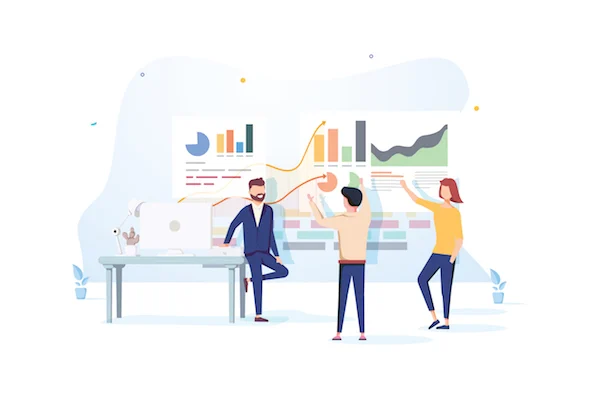

In [293]:
#importing required libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from math import sqrt
from statistics import mean, stdev
from itertools import product
from tqdm import tqdm_notebook

from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime,timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


import warnings
warnings.filterwarnings("ignore")

In [144]:
#fetch the data from kaggle 
#kaggle link - https://www.kaggle.com/datasets/galibce003/perrin-freres-monthly-champagne-sales
df = pd.read_csv('Perrin Freres monthly champagne sales millions.csv')

In [145]:
#check for the shape of given dataframe
df.shape

(107, 2)

In [146]:
#Check for the first rows 
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [147]:
#Check for the last rows 
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


## Data Preprocessing

In [148]:
#check for the NAN values
df.isnull().mean()*100
#since the % of nan value is less than 5%, we can drop the same 

Month                                                     0.934579
Perrin Freres monthly champagne sales millions ?64-?72    1.869159
dtype: float64

In [149]:
#droping the NAN values 
df.dropna(inplace=True)

In [150]:
#check for info of the fetched dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Month                                                   105 non-null    object 
 1   Perrin Freres monthly champagne sales millions ?64-?72  105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [151]:
#changing the dtype of Month to datetime
df['Month'] = pd.to_datetime(df.Month)
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [152]:
#changing the name of columns to appropraite names
df.columns=['Month','Sales']
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [153]:
#setting Month to index
df = df.set_index('Month')
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


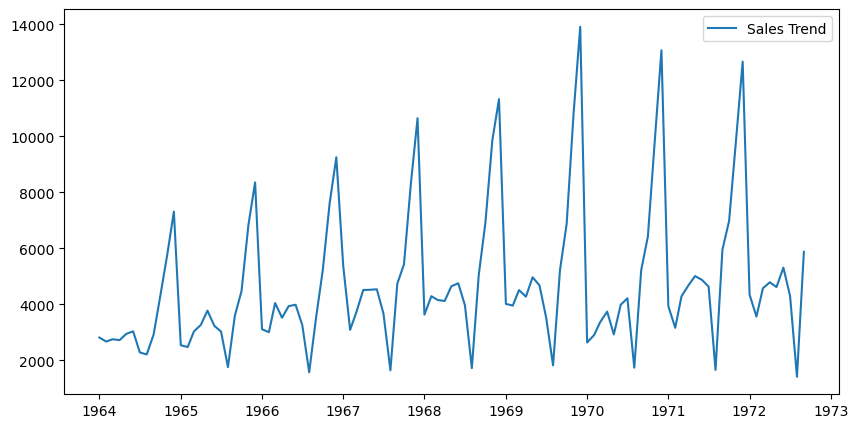

In [154]:
#plotting the sales for visualisation of past trends 
plt.figure(figsize=(10,5))

plt.plot(df.index,df.Sales,label = 'Sales Trend')
plt.legend()
plt.show()

In [155]:
#check for statistics
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


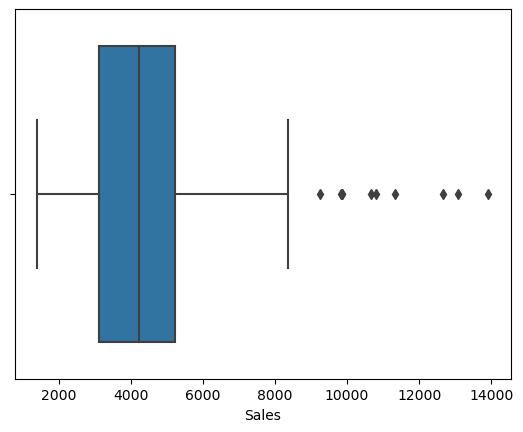

In [288]:
#check for outliers in the give data
sns.boxplot(df.Sales)
plt.show()

#This implies outliers are present in the upper limit 

In [292]:
#Check for outlier using IQR method(IQR method used as the data is not normally distributed)

numerical_feature = ['Sales']

def count_outlier(data,col):
    q1 = data[col].quantile(0.25,interpolation = 'nearest')
    q2 = data[col].quantile(0.5,interpolation = 'nearest')
    q3 = data[col].quantile(0.75,interpolation = 'nearest')
    q4 = data[col].quantile(1.00,interpolation = 'nearest')
    
    IQR = q3 -q1
    global LLP
    global ULP
    
    LLP = q1 - 1.5 * IQR
    ULP = q3 + 1.5 * IQR
    
    if data[col].min() > LLP and data[col].max() < ULP:
        print('No oulier in', i)
    else:
        print('There are outlier in', i)
        x = data[data[col] < LLP][col].size
        y = data[data[col] > ULP][col].size
        a.append(i)
        print('Count of Outlier are :', x+y)
        
global a
a = []
for i in numerical_feature:
    count_outlier(df,i)

print('*'*125)    
    
def whisker_boundaries(col):   
   
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    IQR = q3 - q1

    lower_limit = q1 - 1.5 * IQR
    upper_limit = q3 + 1.5 * IQR

    return lower_limit,upper_limit

lower_value, upper_value = whisker_boundaries('Sales')

print('Lower Whisker Value is:',lower_value)
print('Upper Whisker Value is:',upper_value)

df_outliers = df.loc[df['Sales']>upper_value]
print('The outliers rows are below :')
pd.DataFrame(df_outliers.Sales)

#based on IQR method for detecting outlier we are getting 10 no's as outliers.
#since there is huge difference between 75 percentile and max value,so we will use 95,97 and 99 percentile to check out outliers.

There are outlier in Sales
Count of Outlier are : 10
*****************************************************************************************************************************
Lower Whisker Value is: -49.0
Upper Whisker Value is: 8383.0
The outliers rows are below :


,Sales
Month,
1966-12-01,9254.0
1967-12-01,10651.0
1968-11-01,9858.0
1968-12-01,11331.0
1969-11-01,10803.0
1969-12-01,13916.0
1970-11-01,9842.0
1970-12-01,13076.0
1971-11-01,9851.0


### Check for effect of filling the outliers with upper whiskers

In [159]:
#intialisation of outliers with NAN value
new_df = df.copy()

#replacing outliers with NAN
new_df['Sales'] = new_df['Sales'].apply(lambda x: np.nan if x>upper_value else x)

In [160]:
#check for missing values 
new_df['Sales'].isnull().sum()

10

In [161]:
#fill NAN with last valid observation since the outliers were present in the upper Whisker
new_df['Sales'] = new_df['Sales'].fillna(method='ffill')

In [162]:
#check for missing values
new_df['Sales'].isnull().sum()

0

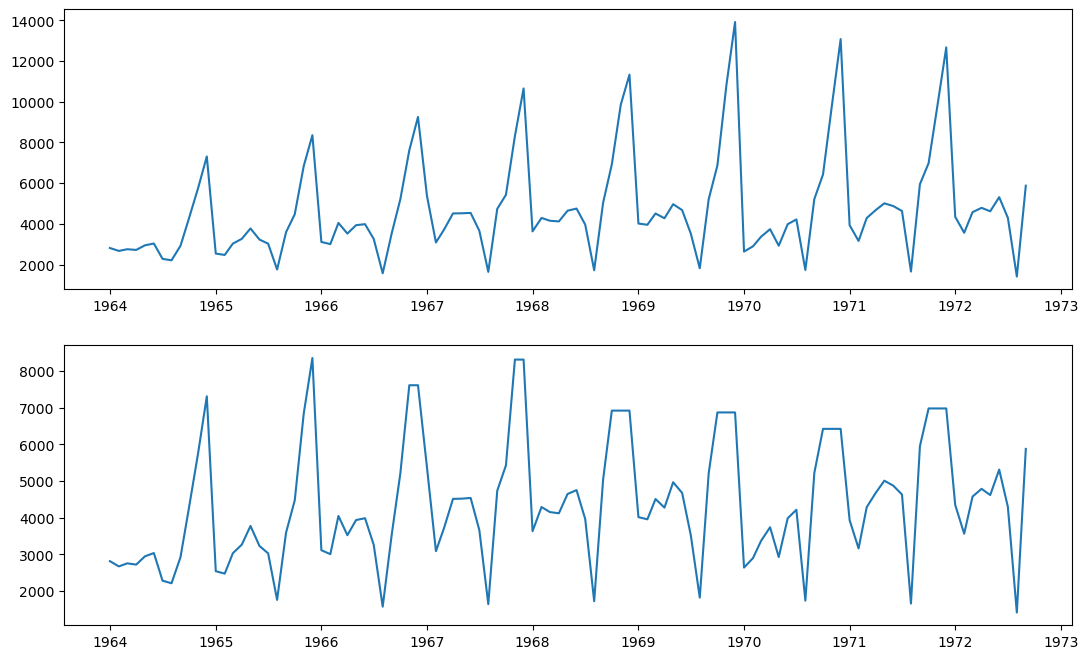

In [163]:
plt.figure(figsize=(13,8))

plt.subplot(2,1,1)
plt.plot(df.index,df.Sales)

plt.subplot(2,1,2)
plt.plot(new_df.index,new_df.Sales)

#since there is change in value of seasonal data, so we will not change the value of outliers to ffil (Will use the df only)

## Feature Extraction and Exploration

In [164]:
#making a copy of df for feature exploration
Data = df.copy()

In [165]:
#feature creation of date in the data dataframe
Data['Date'] =  Data.index
Data.head()

,Sales,Date
Month,,
1964-01-01,2815.0,1964-01-01
1964-02-01,2672.0,1964-02-01
1964-03-01,2755.0,1964-03-01
1964-04-01,2721.0,1964-04-01
1964-05-01,2946.0,1964-05-01


In [166]:
#feature extraction from the date feature of given Dataframe
data_feat = pd.DataFrame({"year": Data['Date'].dt.year,
                          "month": Data['Date'].dt.month,
                          "dayofmonth": Data['Date'].dt.day,
                          "weekday": Data['Date'].dt.dayofweek,
                          "dayofyear": Data['Date'].dt.dayofyear,
                          "week": Data['Date'].dt.week,
                          "quarter": Data['Date'].dt.quarter,
                         })

data_feat.head()

,year,month,dayofmonth,weekday,dayofyear,week,quarter
Month,,,,,,,
1964-01-01,1964,1,1,2,1,1,1
1964-02-01,1964,2,1,5,32,5,1
1964-03-01,1964,3,1,6,61,9,1
1964-04-01,1964,4,1,2,92,14,2
1964-05-01,1964,5,1,4,122,18,2


In [167]:
#feature addition of sales 
complete_data = pd.concat([data_feat,Data['Sales']],axis =1)
complete_data.head()

,year,month,dayofmonth,weekday,dayofyear,week,quarter,Sales
Month,,,,,,,,
1964-01-01,1964,1,1,2,1,1,1,2815.0
1964-02-01,1964,2,1,5,32,5,1,2672.0
1964-03-01,1964,3,1,6,61,9,1,2755.0
1964-04-01,1964,4,1,2,92,14,2,2721.0
1964-05-01,1964,5,1,4,122,18,2,2946.0


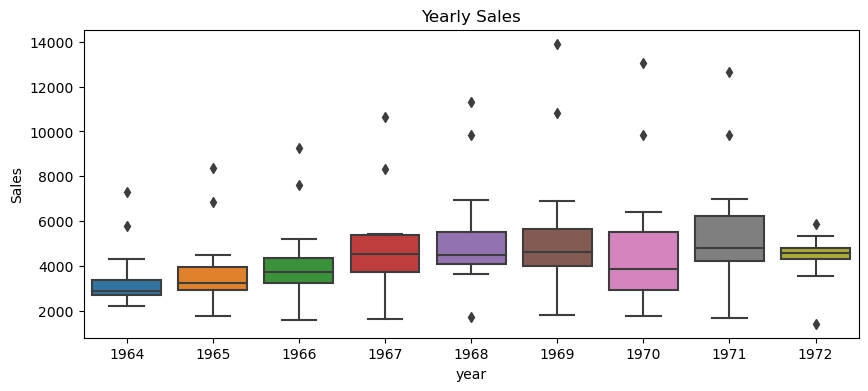

In [168]:
# boxplot for yearly sale
plt.figure(figsize=(10,4))

sns.boxplot(x=complete_data['year'], y=complete_data['Sales'])
plt.title('Yearly Sales')
plt.show()

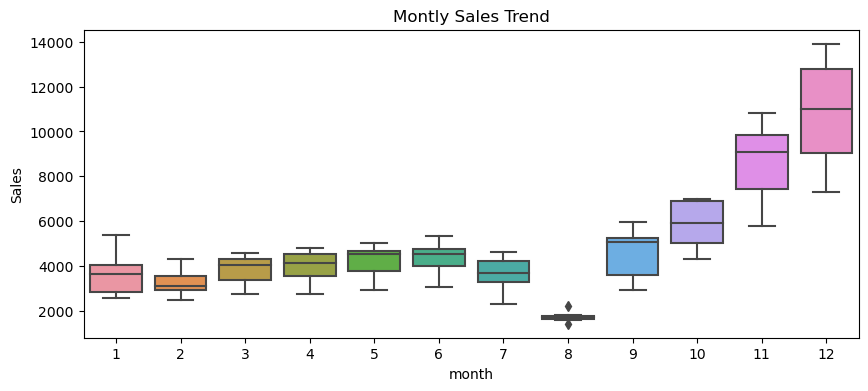

In [169]:
# boxplot for monthly sales
plt.figure(figsize=(10,4))

sns.boxplot(x=complete_data['month'], y=complete_data['Sales'], )
plt.title('Montly Sales Trend')
plt.show()

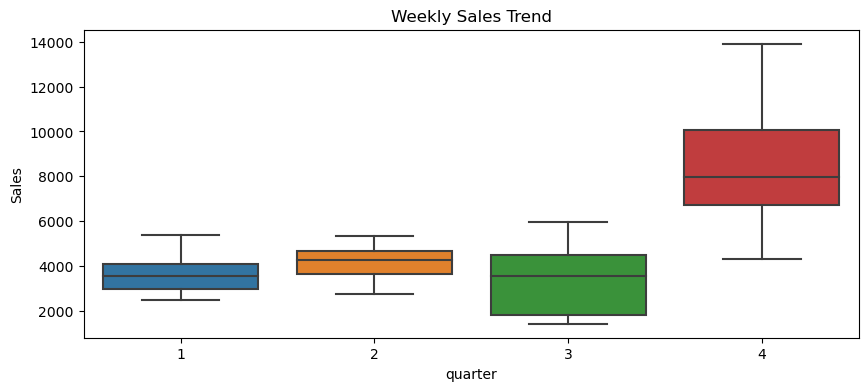

In [170]:
# boxplot for week's sales
plt.figure(figsize=(10,4))

sns.boxplot(x=complete_data['quarter'], y=complete_data['Sales'], )
plt.title('Weekly Sales Trend')
plt.show()

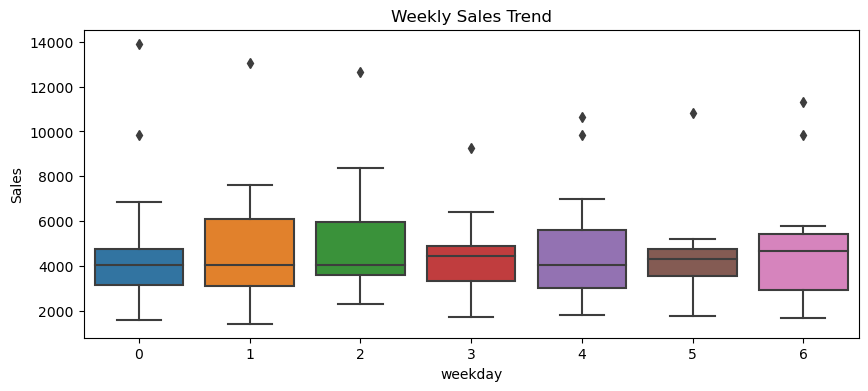

In [171]:
# boxplot for week's day sales
plt.figure(figsize=(10,4))

sns.boxplot(x=complete_data['weekday'], y=complete_data['Sales'], )
plt.title('Weekly Sales Trend')
plt.show()

### **Conclusion on exploration of Data:**
- Highest sale occured in the year of 1971.
- December month got the highest sales compared to other months.
- Week four was having the highest sales in any month.
- Day one was having the highest sale.

## Test for Stationarity

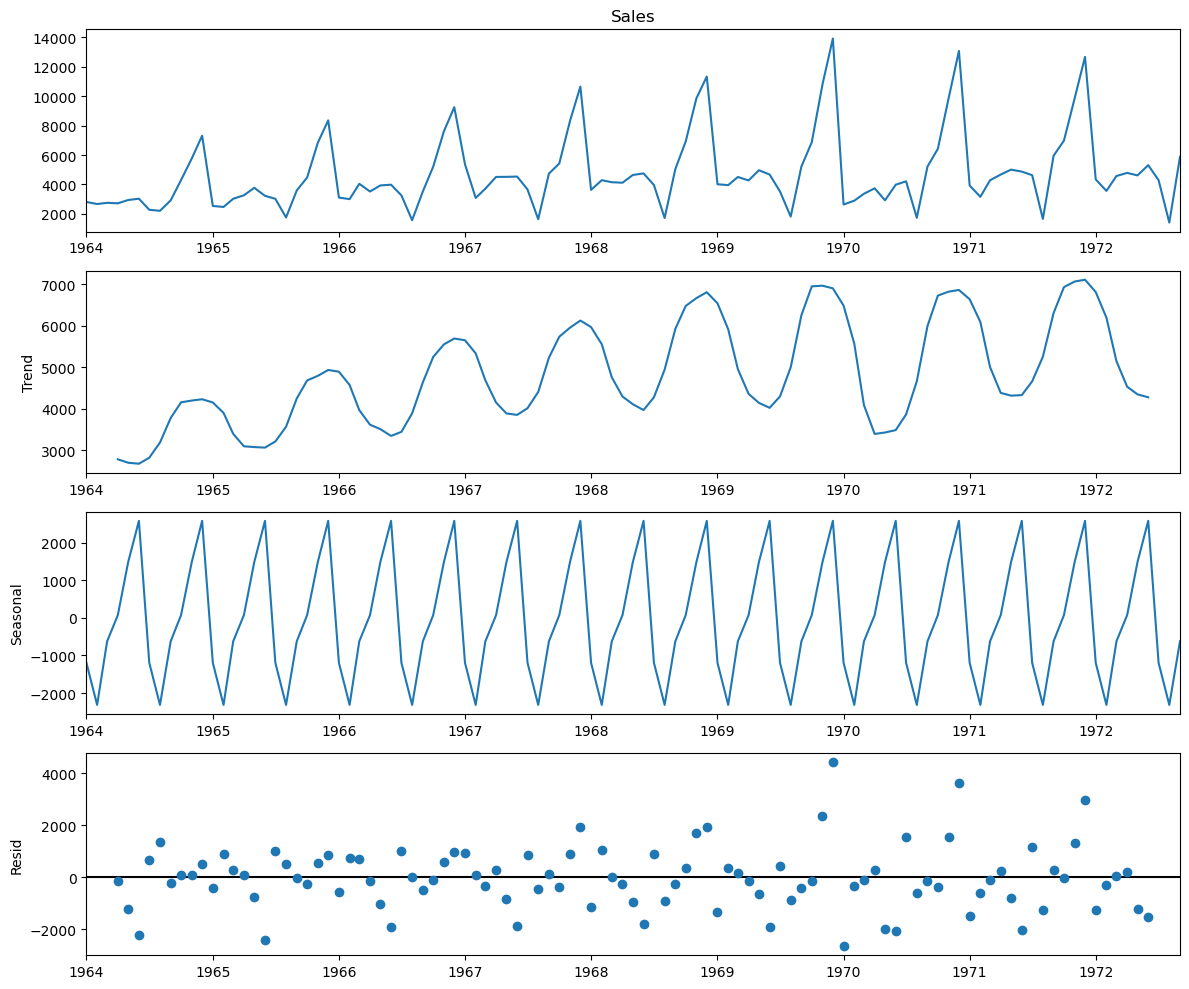

In [172]:
#Through decomposition

decomposed_series = seasonal_decompose(df['Sales'],period=6)

fig = decomposed_series.plot()
fig.set_size_inches((12,10))
fig.tight_layout()

#presence of trends and seasonality in the data implies the given data is not stationary.

In [173]:
#Through adfuller test
def adf_test(series):
    result = adfuller(series)
    print('ADF statistics: {}'.format(result[0]))
    print('P value: {}'.format(result[1]))
    print('No. of lags used : {}'.format(result[2]))
    print('No. of observations used : {}'.format(result[3]))
    
    if result[1]<=0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print('Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary')
        
    
#check for adfuller test on passenger count feature 
adf_test(df['Sales'])    


ADF statistics: -1.8335930563276248
P value: 0.363915771660244
No. of lags used : 11
No. of observations used : 93
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


### Differencing

In [174]:
#shifting the values of Sale by 1 and performing adfuller test
df['Shift First Difference'] = df.Sales - df.Sales.shift(1)
adf_test(df['Shift First Difference'].dropna())

ADF statistics: -7.189896448051015
P value: 2.5196204473868427e-10
No. of lags used : 11
No. of observations used : 92
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [175]:
#shifting the values of Sale by 12 and performing adfuller test
df['Seasonal First Difference'] = df.Sales - df.Sales.shift(12)
adf_test(df['Seasonal First Difference'].dropna())

ADF statistics: -7.626619157213163
P value: 2.060579696813685e-11
No. of lags used : 0
No. of observations used : 92
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:ylabel='Density'>

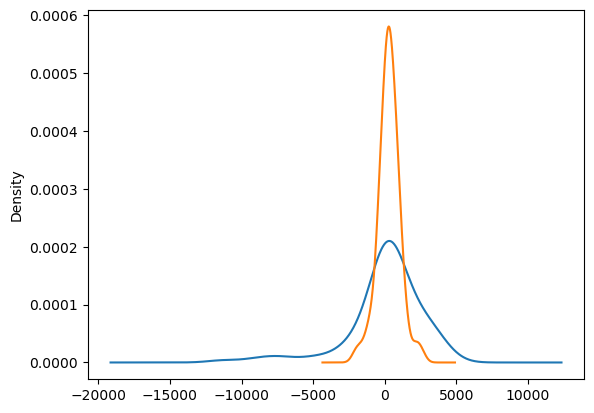

In [176]:
#check for stationary of the shifted values through kde plot
df['Shift First Difference'].plot(kind='kde')
df['Seasonal First Difference'].plot(kind='kde')
##kde plot is uniformally distributed implies the shifted values feature are stationary

# ARIMA MODEL

### Computing p,q and d value for ARIMA Model:

We will try three method to compute best value of p,d and q for ARIMA model.The same are mentioned below:

 1. ACF(q) and PACF plot(p).
 2. Auto_ARIMA method.
 3. Iterations.

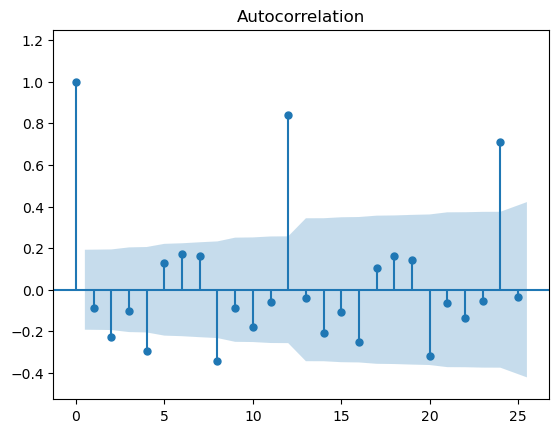

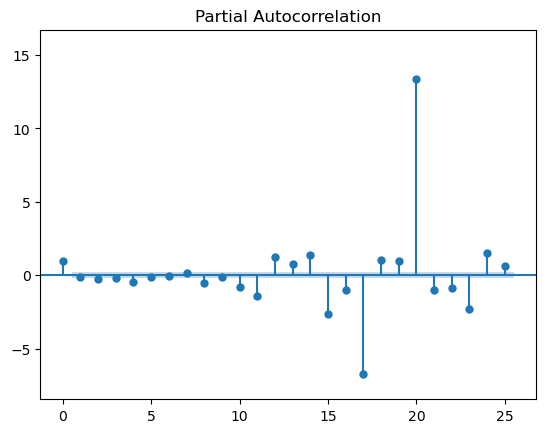

In [177]:
#ACF(q) and PACF plot(p)
plot_acf(df['Shift First Difference'].dropna(), lags=25,auto_ylims=True)
plot_pacf(df['Shift First Difference'].dropna(), lags=25,auto_ylims=True)
plt.show()

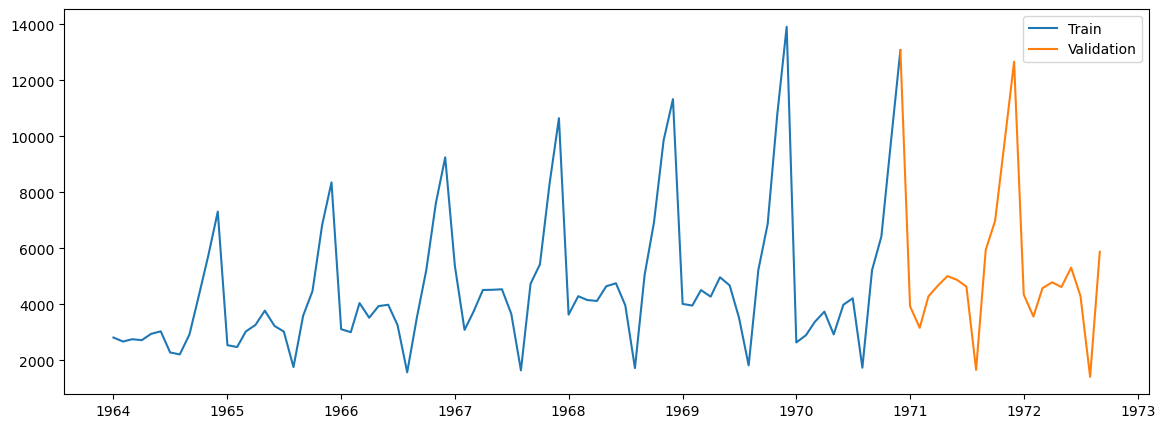

In [242]:
#splitting the data in train vs validation
train_data = df[:84]
validation_data = df[83:]

plt.figure(figsize=(14,5))
plt.plot(train_data.index,train_data.Sales,label='Train')
plt.plot(validation_data.index,validation_data.Sales,label='Validation')
plt.legend()
plt.show()

In [243]:
#fetching the p,q and d value through iter method

start = len(train_data)+1
end = len(train_data)+len(validation_data)

#creating rmse function for calculation of rmse of predicted value with that of validation data
def rmsle(actual, preds):
    
    for i in range(0,len(preds)):
        if preds[i] < 0:
            preds[i] = 0
        else:
            pass
    
    error = (sqrt(mean_squared_log_error(actual, preds)))
    return error

#function for calculation of best p,d and q value
def get_best_params(parameters_list):
        
    for p,d,q in parameters_list:
        
        best_order = None
        least_error = float("inf")
        
        model = ARIMA(train_data['Sales'],order=(p,d,q))
        model_fit = model.fit()
        
        preds = model_fit.predict(start=start,end = end)
        preds.index = validation_data.index

        error = rmsle(actual=validation_data['Sales'],preds=preds)
                
        if error < least_error:
            least_error = error
            best_order = (p,d,q)
            
        
    print('Best ARIMA %s least RMSLE=%.3f' % (best_order,least_error))


In [268]:
# initialisation of p.d and q with some of the values 
p = range(1,8)
d = range(0,6) 
q = range(1,8)

# creating list with all the possible combinations of parameters
parameters = product(p, d, q)
parameters_list = list(parameters)

get_best_params(parameters_list)

Best ARIMA (7, 5, 7) least RMSLE=2.987


In [269]:
#fiting the best order in ARIMA

start = len(train_data['Sales'])-1
end = len(train_data['Sales'])+len(validation_data['Sales'])-2

model = ARIMA(df['Sales'],order=(7,5,7))
model_fit = model.fit()

print(model_fit.summary())
print(''*125)
print('*'*125)
print(''*125)

ar_preds = model_fit.predict(start=start,end = end)
error = rmsle(actual=validation_data['Sales'],preds=ar_preds)
print('RMSLE correponding to optimized (p,d,q) values: %.2f' %error)

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(7, 5, 7)   Log Likelihood                -963.417
Date:                Wed, 17 May 2023   AIC                           1956.834
Time:                        14:05:19   BIC                           1995.911
Sample:                    01-01-1964   HQIC                          1972.649
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.8402      1.034     -2.748      0.006      -4.866      -0.814
ar.L2         -4.2165      3.033     -1.390      0.164     -10.160       1.727
ar.L3         -4.2024      5.003     -0.840      0.4

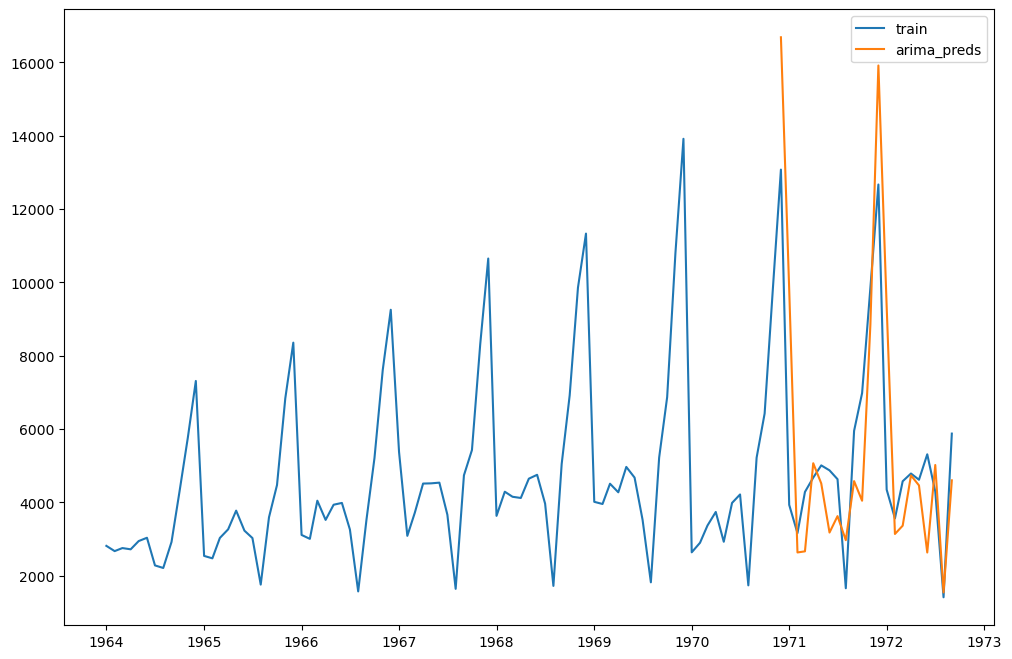

In [271]:
#graph depiction of train VS actual validation VS pred validation

plt.figure(figsize = (12,8))
plt.plot(df.index, df['Sales'], label = 'train')
#plt.plot(validation_data.index, validation_data['Sales'], label = 'valid')
plt.plot(ar_preds.index, ar_preds, label = 'arima_preds')
plt.legend()
plt.show()

In [274]:
#forcasting for next twelve month
forecast_start = df.shape[0]-1
forecast_end = forecast_start + 12

twelve_month_forecast_ar = model_fit.predict(start=forecast_start,end = forecast_end)
print('The future predicted next 6 month sales is as below: ')
twelve_month_forecast_ar

The future predicted next 6 month sales is as below: 


1972-09-01     4601.877419
1972-10-01     4221.353502
1972-11-01     3808.738694
1972-12-01     6865.832100
1973-01-01     3929.983988
1973-02-01     6053.134226
1973-03-01     7808.296643
1973-04-01     8580.155118
1973-05-01     9514.907987
1973-06-01    12494.909802
1973-07-01    15002.861361
1973-08-01    15736.401595
1973-09-01    22662.223700
Freq: MS, Name: predicted_mean, dtype: float64

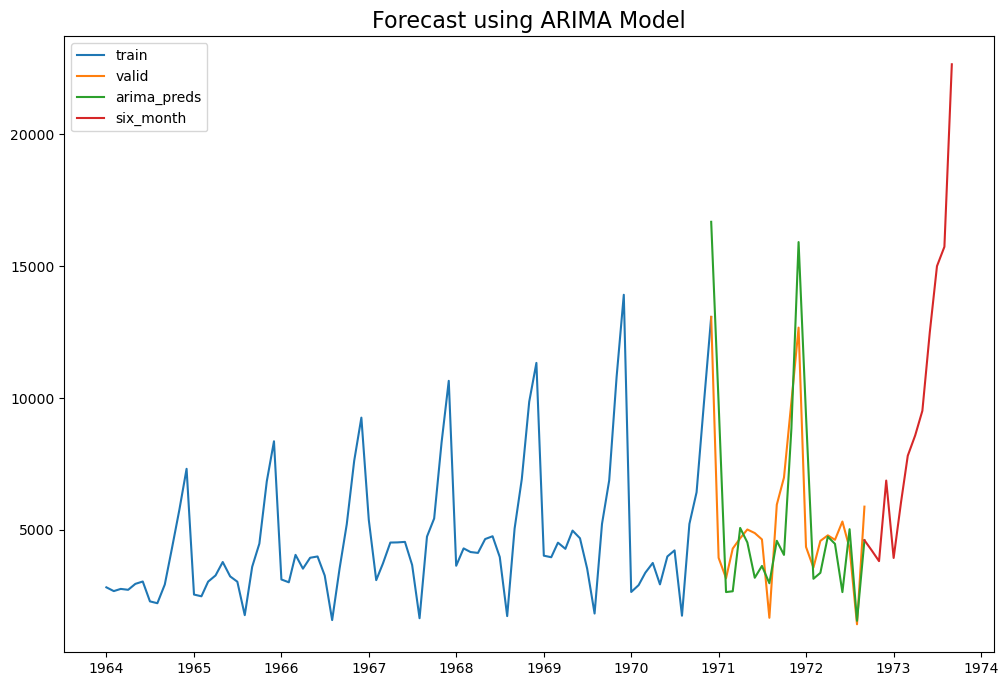

In [275]:
#graph depiction of train VS actual validation VS pred validation VS future forcast
plt.figure(figsize = (12,8))
plt.plot(train_data.index, train_data['Sales'], label = 'train')
plt.plot(validation_data.index, validation_data['Sales'], label = 'valid')
plt.plot(validation_data.index, ar_preds, label = 'arima_preds')
plt.plot(six_month_forecast_ar.index, six_month_forecast_ar, label = 'Twelve_month')
plt.title('Forecast using ARIMA Model', fontsize=16)
plt.legend()
plt.show()
#presence of seasonalality in data leads to failure of ARIMA model 

# SARIMA MODEL

In [190]:
#function to get optimised lags of SARIMA 

def optimize_SARIMA(parameters_list, s = 12):
    """
        Return dataframe with parameters, corresponding AIC and SSE
    """
    
    values = {'p':[],'d':[],'q':[],'P':[],'D':[],'Q':[],'s':[],'RMSLE':[]}
    
    start = len(train_data)+1
    end = len(train_data) + len(validation_data)
    
    for param in tqdm_notebook(parameters_list):
        
        best_order = None
        least_error = float("inf")
        
        model = SARIMAX(train_data['Sales'], order = (param[0], param[1], param[2]), 
                        seasonal_order=(param[3], param[4], param[5], param[6]),initialization='approximate_diffuse').fit()
        
        preds = model.predict(start = start,end = end)
        
        
        preds.index = validation_data.index

        error = rmsle(actual=validation_data['Sales'],preds=preds)
        
        values['p'].append(param[0])
        values['d'].append(param[1])
        values['q'].append(param[2])        
        values['P'].append(param[3])
        values['D'].append(param[4])
        values['Q'].append(param[5])
        values['s'].append(param[6])
        
        values['RMSLE'].append(error)
        
        if error < least_error:
            least_error = error
            best_order = param
    
        
        optimize_SARIMA_param = pd.DataFrame(values)
    print('Best SARIMA (p,d,q,P,D,Q,s) = %s least RMSLE = %.3f' % (best_order,least_error))
    return optimize_SARIMA_param

In [193]:
p = range(2)
d = range(2)
q = range(2)
P = range(3)
D = range(2)
Q = range(3)
s = range(5,13)
parameters = product(p,d,q,P, D, Q,s)
parameters_list = list(parameters)
print(len(parameters_list))

1152


In [194]:
optimize_SARIMA(parameters_list)

  0%|          | 0/1152 [00:00<?, ?it/s]

Best SARIMA (p,d,q,P,D,Q,s) = (1, 1, 1, 2, 1, 2, 12) least RMSLE = 0.951


,p,d,q,P,D,Q,s,RMSLE
0,0,0,0,0,0,0,5,8.490468
1,0,0,0,0,0,0,6,8.490468
2,0,0,0,0,0,0,7,8.490468
3,0,0,0,0,0,0,8,8.490468
4,0,0,0,0,0,0,9,8.490468
...,...,...,...,...,...,...,...,...
1147,1,1,1,2,1,2,8,0.717503
1148,1,1,1,2,1,2,9,0.669666
1149,1,1,1,2,1,2,10,0.664251
1150,1,1,1,2,1,2,11,0.611922


In [276]:
#training and fetcting the prediction through best param

start = len(train_data['Sales'])-1
end = len(train_data['Sales'])+len(validation_data['Sales'])-2

model = SARIMAX(df['Sales'],order=(1,1,1),seasonal_order=(1,1,1,12),dynamic=True)
model_fit = model.fit()

print(model_fit.summary())

sarima_preds = model_fit.predict(start=start,end = end)

error = rmsle(actual=validation_data['Sales'],preds=sarima_preds)

print(''*125)
print('*'*125)
print(''*125)
print('RMSLE correponding to optimized (p,d,q) vlaues: %.2f' %error)

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Wed, 17 May 2023   AIC                           1486.804
Time:                                    14:08:18   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043   

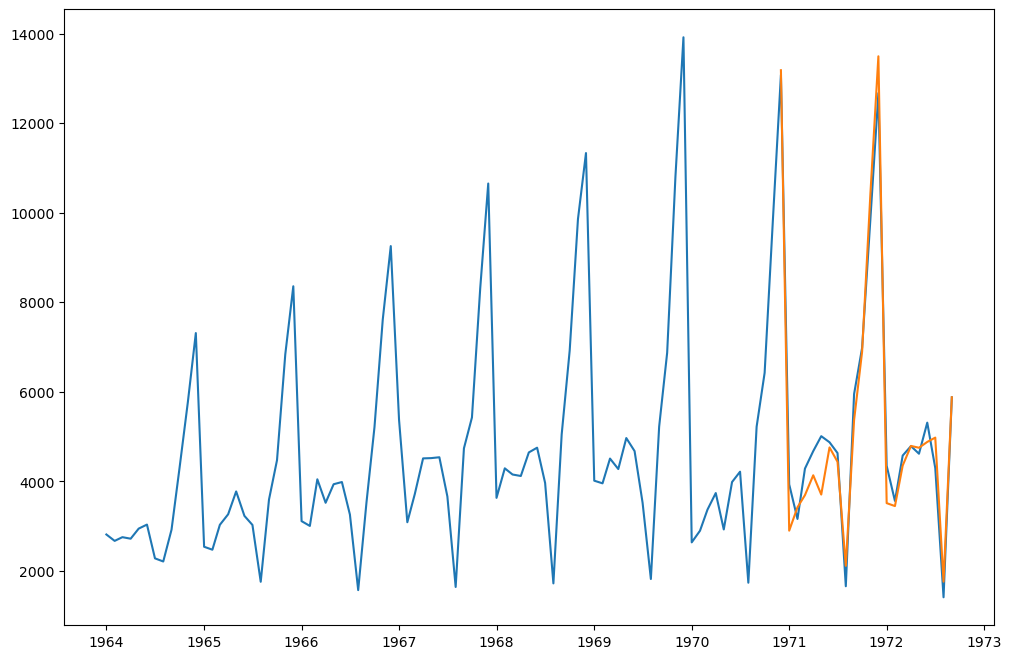

In [277]:
plt.figure(figsize = (12,8))
plt.plot(df.index, df['Sales'], label = 'train')
#plt.plot(validation_data.index, validation_data['Sales'], label = 'valid')
plt.plot(sarima_preds.index, sarima_preds, label = 'sarima_preds')
plt.show()

In [286]:
#forcasting for next twelve month
forecast_start = df.shape[0]-1
forecast_end = forecast_start + 11

twelve_month_forecast_sarima = model_fit.predict(start=forecast_start,end = forecast_end)
print("The future predicted next 12 month's sales is as below: ")
twelve_month_forecast_sarima

The future predicted next 12 month's sales is as below: 


1972-09-01     5878.711925
1972-10-01     7023.698884
1972-11-01     9996.175773
1972-12-01    12891.998084
1973-01-01     4561.379670
1973-02-01     3718.694773
1973-03-01     4792.240095
1973-04-01     5034.490105
1973-05-01     5047.836459
1973-06-01     5488.453085
1973-07-01     4593.507692
1973-08-01     1676.018403
Freq: MS, Name: predicted_mean, dtype: float64

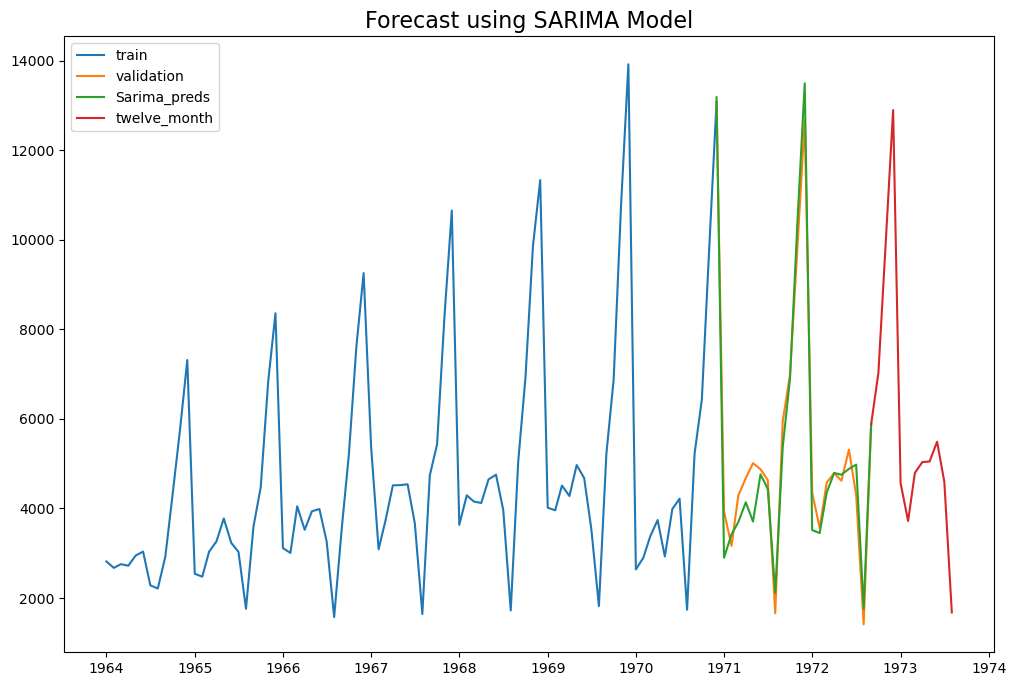

In [287]:
#graphical representation of the Sarima prediction and b
plt.figure(figsize = (12,8))
plt.plot(train_data.index, train_data['Sales'], label = 'train')
plt.plot(validation_data.index, validation_data['Sales'], label = 'validation')
plt.plot(sarima_preds.index, sarima_preds, label = 'Sarima_preds')
plt.plot(twelve_month_forecast_sarima.index, twelve_month_forecast_sarima, label = 'twelve_month')
plt.title('Forecast using SARIMA Model', fontsize=16)
plt.legend()
plt.show()

# Summary of Project

### **The summary of the steps executed in ML model are:**

**1. Data collection and overview of the dataframe:**
- The data was extracted from csv file downloaded from kaggle.
- Data consist of 107 rows and 2 columns.
- Intuition of the data was gained via calling the first five and last five rows.
- There were 2 rows with NAN value.

**2. Data Preprocessing:**
- There were ~1-2 % of NAN value in the given feature of dataframe. So the same was dropped.
- Check for outlier using IQR method.
- There were 10 outliers in the upper limit of the data.
- Check was made to replace the values above upper whiskers with upper whiskers. Since there was drastic change in seasonality of data so self has retained the outliers.

**3. Feature Extraction and Exploration:**

Feature like year, month, date,week and weekday was extracted from the date feature of dataframe in order to check the trend of sale with respect to year, month, date,week and weekday. The following conclusion was drawn on fetching the plots:
- Highest sale occured in the year of 1971.
- December month got the highest sales compared to other months.
- Week four was having the highest sales in any month.
- Day one of week was having the highest sale.
    
**4. Check for Stationarity of data:**

The data was tested for Stationarity via adfuller test. The value of sales was checked with adfuller test. The test depeicted value of p > 0.05 which implies the data is not stationary. Thereafter shifting the values of Sale by 1 and performing adfuller test resulted in p value<=0.05 which implied that data is stationary on shifting the value by 1 and subtracting from the original sale value at same corresponding date. Since there was seasonality in data self has checked shifted the sales value by 12 and subtracted from the original sales value at same corresponding dates.The same passed the adfuller test as well. KDE plot was plotted represented shifted data sales is uniformally distributed which in turn implies stationarity of data.

**5. ARIMA Model building:**

Self has computed p,q and d value for ARIMA Model via two method:
- Plotting graphs ACF and PACF plot for computing p and q value respectively.
- Iterations method.

Based upon the result from ACF/ PACF plot and iteration method value of p,d,q was finalised to 7,5,7 respectively.Further via above fetched order values, ARIMA model was fit/trained and validation sales value was predcited. Thereafter futher 12 month values was predicted. Since there was seasonality data in the given data frame, ARIMA model failed to provide desired results.

**6. SARIMA Model building:**

Futhermore to the results obtained from ARIMA model, SARIMA model was fitted to the given data set after iterating the best value of p,d,q,P,Q,D,s.Further via above fetched order values, SARIMA model was fit/trained and validation sales value was predcited. Thereafter futher 12 month values was predicted. SARIMA Model was predicting the result with RMSE error of **0.14** which resulted in a clean smooth expected plot of sales w.r.t time. Hence the SARIMA model was finalised for predicting the future sales value forecast.